# Steady-State: Time-dependent (periodic) quantum system

Authors: J.R. Johansson and P.D. Nation

Updated by: M. Gobbo (2024)

### Introduction
In this notebook, we will find the steady-state of a driven qubit using the `steadystate()`, `propagator_steadystate()`, and `steadystate_floquet()` solver methods. The results will be compared with the master equation solver `mesolve()` implemented in QuTiP.

You can also find more on solving for steady-state solutions with QuTiP [here](https://qutip.readthedocs.io/en/latest/guide/guide-steady.html).

### Imports
Here we import the required modules for this example.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from qutip import (
    about,
    basis,
    destroy,
    expect,
    mesolve,
    steadystate,
    propagator,
    propagator_steadystate,
    sigmax,
    sigmaz,
    steadystate_floquet,
)

### System setup
We consider a driven system with the following Hamiltonian: 

$$ H = - \frac{\Delta}{2} \sigma_x - \frac{\epsilon_0}{2} \sigma_z + \frac{A}{2} \sigma_z \sin(\omega t) $$

We also assume a coupling with the external heat bath described by a coupling constant $\kappa_1$, the temperature of the heat bath is defined via the average photon number $\langle n \rangle$. In addition, we assume a variation in the phase of the qubit described by a collapse operator with a constant $\kappa_2$.

In [2]:
# Parameters
delta = (2 * np.pi) * 0.3
eps_0 = (2 * np.pi) * 1.0
A = (2 * np.pi) * 0.05
w = (2 * np.pi) * 1.0
kappa_1 = 0.15
kappa_2 = 0.05

# Operators
sx = sigmax()
sz = sigmaz()
sm = destroy(2)

# Non-driving Hamiltonian
H0 = -delta / 2.0 * sx - eps_0 / 2.0 * sz

# Driving Hamiltonian
H1 = A / 2.0 * sz
args = {"w": w}

# Total Hamiltonian
H = [H0, [H1, "np.sin(w*t)"]]

# Collapse operators
c_op_list = []

# Thermal population
n_th = 0.5

# Relaxation
rate = kappa_1 * (1 + n_th)

if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * sm)

# Excitation
rate = kappa_1 * n_th

if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * sm.dag())

# Dephasing
rate = kappa_2
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * sz)

### Time evolution

In [3]:
# Period
T = 2 * np.pi / w

# Simulation time
t_list = np.linspace(0, 50, 500)

# Initial state
psi_0 = basis(2, 0)
psi_1 = basis(2, 1)

### Master equation

In [4]:
# Solve with the Master equation
output = mesolve(H, psi_0, t_list, c_op_list, [psi_1 * psi_1.dag()], args)
prob_me = output.expect[0]

/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip/solver/solver_base.py:598: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip/solver/solver_base.py:598: FutureWarning: args will be keyword only from qutip 5.3 for all solver
  warnings.warn(
/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip/core/coefficient.py:423: UserWarning: `cython`, `setuptools` and `filelock` are required for compilation of string coefficents. Falling back on `eval`.
  warnings.warn(


### Steady-state method
This function implements several different methods for finding the steady-state, each with their pros and cons. For this case, we use the default parametrization, `method="direct"` and `solver="solve"` which solves for

$$
\frac{d\hat \rho_{ss}}{dt} = \mathcal{L}\hat \rho_{ss} = 0
$$

`H0` is the quantum object representing the non-driving Hamiltonian, and `c_ops` is a list of quantum objects for the system collapse operators. The output, labeled as `rho_ss`, is the steady-state solution for the systems. When the default direct method is used, it is generated a solution that is exact to machine precision at the expense of a large memory requirement. The large amount of memory needed for the direct LU decomposition method stems from the large bandwidth of the system Liouvillian and the correspondingly large fill-in (extra nonzero elements) generated in the LU factors.

More details for the steady-state methods and solvers can be found in [Steady-state solution methods for open quantum optical systems](https://arxiv.org/abs/1504.06768) by P. D. Nation.

In [5]:
# Evaluate the steady-state using the steadystate method
rho_ss = steadystate(H0, c_op_list, method="direct", solver="solve")
prob_ss = expect(psi_1 * psi_1.dag(), rho_ss)

### Propagator method
In this case, with the `propagator` method, we evaluate the propagator $U(t)$ for the density matrix or wave function such that
$$
\psi(t) = U(t)\psi(0) \qquad \text{or} \qquad \rho_\text{vec}(t) = U(t)\rho_\text{vec}(0)
$$
where $\rho_\text{vec}$ is the vector representation of the density matrix.

`H` is the time-dependent system Hamiltonian, `T` represents the time for which to evaluate the propagator. If a single time is passed, the propagator from $0$ to $T$ is computed, `c_ops` is a list of quantum objects for the system collapse operators, and `args` are the parameters to callback functions for time-dependent Hamiltonians and collapse operators.
Afterward, the `propagator_steadystate` method takes the propagator evaluated before and finds the steady-state for successive applications of the propagator. Computationally, evaluates the eigenvalues and eigenstates for $U(t)$, identifies the closest value to $1$ defined as the steady-state, and builds the normalized density matrix `rho_pss`.

In [6]:
# Evaluate the steady-state using the propagator method
U = propagator(H, T, c_op_list, args)
rho_pss = propagator_steadystate(U)
prob_pss = expect(psi_1 * psi_1.dag(), rho_pss)

### Floquet method
In this last case, the `steadystate_floquet` method computes the effective-steady state for a driven system with a time-dependent sinusoidal term. From `H0` using `c_ops` and `H1` we build their respective Liouvillian superoperator: $\mathcal{L}_0$, $\mathcal{L}_m$ and $\mathcal{L}_p$. The first term is associated with the non-driving Hamiltonian while the last two terms are the positive and negative frequency of the driving Hamiltonian. Overall we have
$$
\mathcal{M} = \mathcal{L}_0 + \mathcal{L}_m e^{-i\omega t} + \mathcal{L}_p e^{i\omega t}
$$
where $\omega$ is the drive frequency. Finally, the $\mathcal{M}$ superoperator is used to evaluate the steady-state using the `steadystate` method presented previously.

In [7]:
# Evaluate the steady-state using the Floquet method
rho_fss = steadystate_floquet(H0, c_op_list, H1, w)
prob_fss = expect(psi_1 * psi_1.dag(), rho_fss)

### Results

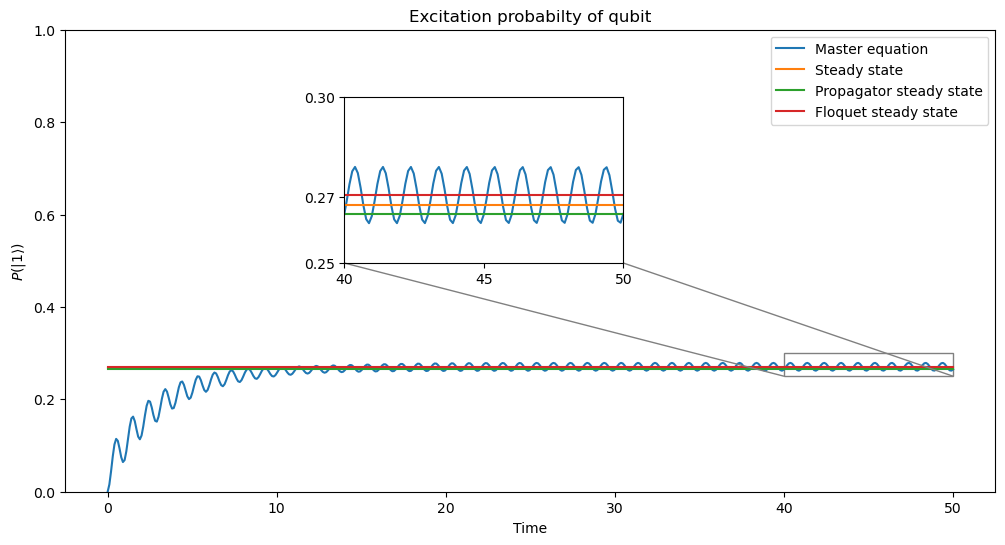

In [8]:
# Figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot
ax.plot(t_list, prob_me, label="Master equation")
ax.plot(t_list, prob_ss * np.ones(t_list.shape[0]), label="Steady state")
ax.plot(t_list, prob_pss * np.ones(t_list.shape[0]), label="Propagator steady state")
ax.plot(t_list, prob_fss * np.ones(t_list.shape[0]), label="Floquet steady state")
ax.set_ylim(0, 1)

# Inset
ax_inset = inset_axes(
    ax,
    width="60%",
    height="80%",
    loc="center",
    bbox_to_anchor=(0.2, 0.45, 0.5, 0.45),
    bbox_transform=ax.transAxes,
)
ax_inset.plot(t_list, prob_me, label="Master Equation")
ax_inset.plot(t_list, prob_ss * np.ones(t_list.shape[0]), label="Steady state")
ax_inset.plot(
    t_list, prob_pss * np.ones(t_list.shape[0]), label="Propagator steady state"
)
ax_inset.plot(t_list, prob_fss * np.ones(t_list.shape[0]), label="Floquet steady state")
ax_inset.set_xlim(40, 50)
ax_inset.set_ylim(0.25, 0.3)
ax_inset.set_xticks([40, 45, 50])
ax_inset.set_yticks([0.25, 0.27, 0.3])
mark_inset(ax, ax_inset, loc1=3, loc2=4, fc="none", ec="0.5")

# Labels
ax.set_xlabel("Time")
ax.set_ylabel("$P(|1\\rangle)$")
ax.set_title("Excitation probabilty of qubit")
ax.legend()
plt.show()

### About

In [9]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------

qutip-qtrl: 

qutip-jax: 0.1.1.dev6
qutip-qip: 0.5.0.dev0+81a92b9

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


### Testing

In [10]:
np.testing.assert_allclose(prob_ss, np.mean(prob_me[200:]), atol=1e-2)
np.testing.assert_allclose(prob_pss, np.mean(prob_me[200:]), atol=1e-2)
np.testing.assert_allclose(prob_fss, np.mean(prob_me[200:]), atol=1e-2)
np.testing.assert_allclose(prob_ss, prob_pss, atol=1e-2)
np.testing.assert_allclose(prob_ss, prob_fss, atol=1e-2)
np.testing.assert_allclose(prob_pss, prob_fss, atol=1e-2)